# Spoken Digit Classification
<br/>
<center>Francesco Di Salvo <br/> <i>Politecnico di Torino <br /> s282418@studenti.polito.it</i></center>
<br />

## Abstract
This document focuses on the Classification model used for predicting spoken digits, recorded in different circumstances. The used dataset contains 2000 spoken digits recorded by four people of numbers from 0 to 9 in English. We had 1500 spoken digits available for the developement phase, and the remaining 500 for the evalutation phase. Each audio track was recorded with a bit rate of 8KHz and proposed as a '.wav' file. I explored the recordings both in the time and frequency domain, in order to gain more insights and I pre-processed the data in a proper way. For the classification model I used the "Random Forest Classifier" and I tried to give it pre-processed data in both time and frequency domain, and I obtained the best performance by feeding it with mel-frequency cepstral coefficients (MFFcs) that are derived from a type of cepstral representation of the audio clip. After an adequate hyperparameters tuning phase, I found the best hyperparameters for the predicting model that allowed me to perform a 0.996 accuracy. 
    
## Data extraction
The data used for the developement and evaluation phase have a different format. In fact the developement dataset contained the files called with the format "id_label.wav" and of course in the evaluation set we had the format "id.wav". So, in order to manage these differences I developed one single method for the extraction of the information that requires the kind of data needed, with the keywords 'eval' and 'dev'. In order to extract the informations. I used the python's libraries "os" and "scipy". In particular the first one is used for taking the recording names of the current directory, and the second one, thanks to the "wavfile" module is used for read the audio files. The method wavfile.read() returns in output the sample rate and the samples of the audio tracks, that is actually the amplitude on each time stamp. After this process I had six objects, two arrays containing the sample rates of the audio signals (eval and dev), two samples of the collections (eval and dev) and two other arrays, containing the labels for the developement set and the indices for the evaluation set. 

In [13]:
import os 
import numpy as np
from scipy.io import wavfile

def get_data(type):
    
    if type not in ['eval','dev']:
        print("-- Parametro non riconosciuto")
        exit(0)
    
    # folder containing both eval and dev folders
    path = '../Datasets/free-spoken-digit/' + type + '/'
    
    # get all the elements from the requested path
    audio_files = os.listdir(path)
    
    # we have to initialize them
    # otherwise we cannot have access trough indices
    X = [None for i in range(len(audio_files))]
    y = [None for i in range(len(audio_files))]
    rates = [None for i in range(len(audio_files))]
    id_audio = None
    
    for audio_file in audio_files:
        
        """
            eval and dev have two different structures
                dev  : id_label.wav
                eval : id.wav 
        """ 
        
        if type == "dev":
            id_audio = int(audio_file.split("_")[0])
            y[id_audio] = int(audio_file.split(".")[0].split("_")[1])
        else:
            id_audio = int(audio_file.split(".")[0])
            y[id_audio] = id_audio
        
        complete_path = path + audio_file
        
        # read the content of the audio file
        rates[id_audio], X[id_audio] = wavfile.read(complete_path)

    return rates, X, y 

In [14]:
Rates_eval, X_eval, ids  = get_data('eval')
Rates_dev,  X_dev, y_dev = get_data('dev')

## Data exploration
From what I obtained so far, I started looking for some insights. The first thing that I looked for, was the Sample Rate. In particular I checked if all the recordings was recorded with the same sample rate of 8KHz, so in order to check that, I just converted the lists of sample rates into a set, because in this manner I avoided the duplicates. The result was as I expected, so both developement and evaluation datasets were recorded with the same sample rate of 8KHz.

After that, I plotted the amplitude in order to see graphically the audio tracks. I used in particular matplotlib and seaborn, that are two of the most common visualization libraries. The infographic gave me two significant informations: the recordings have different lengths and a huge variance among the amplitudes. In fact in the next process, I tried to  solve those issues as much as I could. 

In [3]:
# avoid duplicates
print("Rates eval :\t", set(Rates_eval))
print("Rates dev  :\t", set(Rates_dev))

Rates eval :	 {8000}
Rates dev  :	 {8000}


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_amplitude(X):
    sns.set_style("darkgrid")
    plt.figure(figsize=(12,6))

    for i,x in enumerate(X):

        length = x.shape[0] / Rates_dev[i]
        time = np.linspace(0., length, x.shape[0])
        plt.plot(time, x, alpha=0.5)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        
    plt.show()

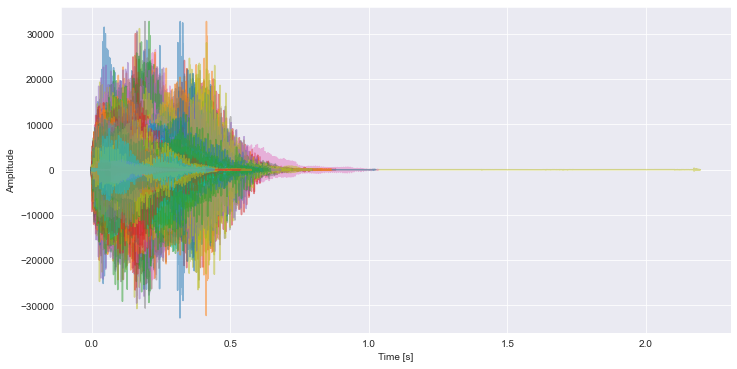

In [7]:
plot_amplitude(X_dev)

## Preprocessing
Thanks to the insights that I found during the exploratory analysis, I focused the attention on the lengths and the amplitudes. So, firstly, I normalized the data, in order to deal with more homogeneous signals. I used the z-score normalization, that substracts each value with the mean, and divide it with the standard deviation. The computation is already provided by Scipy, on its module "stats". After that, I created a list with all the audios' lenghts, and then I plotted them as an histogram. It showed that the most common lengths were around 3000 to 3500, and the less common ones were up to 6000. So, I decided to trim all the tracks at 6000 and I stretched the shorter ones to 6000 by adding 0 to the remaining positions. This process will improve the model performance, because Random Forest (such as many other algorithms ) works better with less attributes. Actually, I tried to trim the signals at 6000 and 5000 and it seemed that the perfomance didn't improve at all, so I maintained the treshold at 5000.

After these considerations in the time domain I decided to move to the frequency domain. Actually, as a first try, I feeded the Random Forest with the FFT (fast fourier transformed - a function that converts a signal from the time domain to the frequency domain) and I obtained such a good result. Then, while I was discussing with Andrea Cognolato (one of my collegues), he suggested me to have a look on the SFTF (Short-time Fourier transform) and on the MFC (mel-frequency Cepstrum). To be more precise, the STFT divides the signal into chunks and then it compute the fast fourier transformed on each chunk, separately; then the second one (MFC) is a representation of the short-term power spectrum of a sound. 

So, I tried to feed the RandomForestClassifier with the output of the SFTF and I actually improved my current performance, but when I used the MFCC I noticed a wider increment, in fact it allowed to achieve a score of 0.996. Furthermore, I decided to use the MFCC for transforming the signals to the frequency domain. 

In order to do that, I used librosa, a powerful library that allows to manipulate audio signals. The output of the librosa's MFCC method is actually a collection of indices, organized in a matrix. So it is a collection of matrix, and in order to give it to the classifier, I shaped it into a 2-D array, by transforming each matrix into a single array. Of course it is possible because we had a fixed length of signals, so those coefficients will have a fixed dimension too. 

In [15]:
from scipy.stats import zscore

def normalize(X):
    return [zscore(arr) for arr in X]

X_dev_norm = normalize(X_dev)
X_eval_norm = normalize(X_eval)

Text(0.5, 1.0, 'length_eval')

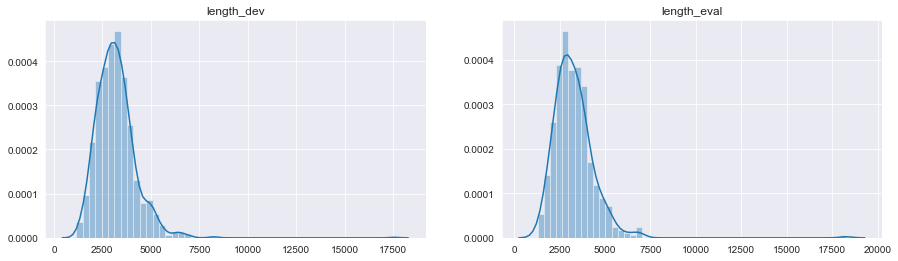

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

# collections of audio lengths
lengths_dev = [ len(audio) for audio in X_dev]
lengths_eval = [ len(audio) for audio in X_eval]

fig, ax = plt.subplots(1,2,figsize=(15,4))

# histograms
sns.distplot(lengths_dev, ax=ax[0])
ax[0].set_title('length_dev')
sns.distplot(lengths_eval, ax=ax[1])
ax[1].set_title('length_eval')

In [42]:
def cut_and_stretch(X, threshold):
    # trim the arrays to a fixed length given as input
    temp =  [ arr if len(arr) <= threshold else arr[:threshold] for arr in X ]
    # stretch the shortest ones
    return  [np.pad(x, (0,thres-len(x)), constant_values=0.0) for x in temp]

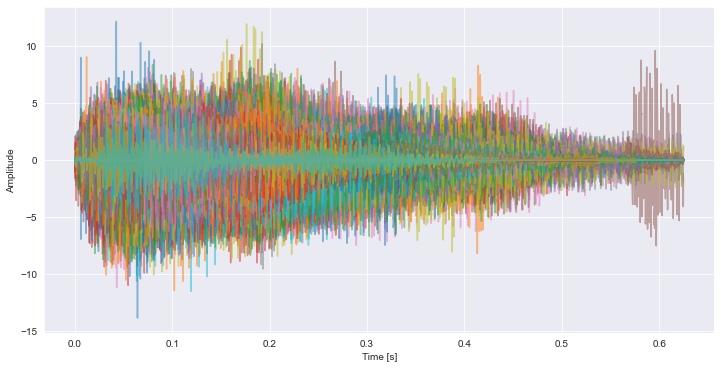

In [43]:
thres = 5000
X_dev_cut = cut_and_stretch(X_dev_norm,thres)
X_eval_cut = cut_and_stretch(X_eval_norm,thres)
plot_amplitude(X_dev_cut)

In [90]:
import librosa, librosa.display, librosa.core
import pandas as pd

MFCCs = [np.matrix(librosa.feature.mfcc(x)).flatten() for x in X_dev_cut ]
MFCCs_eval = [np.matrix(librosa.feature.mfcc(x)).flatten() for x in X_eval_cut ]

In [91]:
"""
    The output is a list of matrix
        I transformed each matrix as a list, by appending the other rows to the first one
"""
MFCCs = np.array(MFCCs).transpose(1,0,2).reshape(1500,200)
MFCCs_eval = np.array(MFCCs_eval).transpose(1,0,2).reshape(500,200)

## Classification model
Once I transformed the initial signals, I started to build the classification model. I decided to use a Grid Search Cross Validation in order to take the best hyperparameters and I have chosen to try different values of "max_dept" (10,50,100,200) and "n_estimators" (500,1000,2000) and 4 folds for the evaluation process. The best parameters were max_depth equal to 200, and n_estimators equal to 2000. After that, I tested these hyperparameters with different randomized train set and test set, and I obtained results from around 0.97 to 0.99. Therefore I finished to work on my model and I predicted the evaluation set with the previous Random Forest Classifier. Actually, I did one last submission with the normalized MFFCs and I obtained a lower score on the submission (0.988), so I decided to maintain the MFCC coefficient without normalization. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# hyperparams 
params_grid = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [10,50,100,200]
}

X_train, X_test, y_train, y_test = train_test_split(MFCCsy_dev, test_size=0.20, stratify=y_dev)

clf_init = RandomForestClassifier()

clf = GridSearchCV(clf_init, params_grid, cv=4, scoring='f1_macro', n_jobs=-1)
clf.fit(X_train, y_train)

In [ ]:
clf.best_params_

In [97]:
X_train, X_test, y_train, y_test = train_test_split(MFCCs,y_dev, test_size=0.20, stratify=y_dev)
rf = RandomForestClassifier(max_depth = 200, n_estimators = 1000)

In [ ]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test,y_pred))

In [106]:
rf.fit(MFCCs,y_dev)
y_final = rf.predict(MFCCs_eval)

## CSV Conversion and deploy
The submission must have a specific structure, so I needed to convert the predicted array into a pandas' dataframe by using the ids vector, obtained in the extraction phase - they were the name of the recording - and the predicted labels. I finally converted that into a csv file that I submitted to the proposal platform. 

In [107]:
def get_csv(ids, y):
    pd.DataFrame(dict(Id = ids,Predicted = y)).to_csv("submission.csv",sep=",",index=False)

In [110]:
get_csv(ids,y_final)